In [1]:
%cd ../..
%pwd

/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/root/CoTFaithChecker'

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚙️  running on cuda
✓ steering vectors: problem_restating·4096, uncertainty_or_certainty_expression·4096, logical_deduction·4096


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.77s/it]


▶ probing: orig


orig: 100%|██████████| 10/10 [00:57<00:00,  5.70s/it]


▶ probing: problem_restating


problem_restating: 100%|██████████| 10/10 [00:56<00:00,  5.66s/it]


▶ probing: uncertainty_or_certainty_expression


uncertainty_or_certainty_expression: 100%|██████████| 10/10 [00:56<00:00,  5.67s/it]


▶ probing: logical_deduction


logical_deduction: 100%|██████████| 10/10 [00:56<00:00,  5.68s/it]


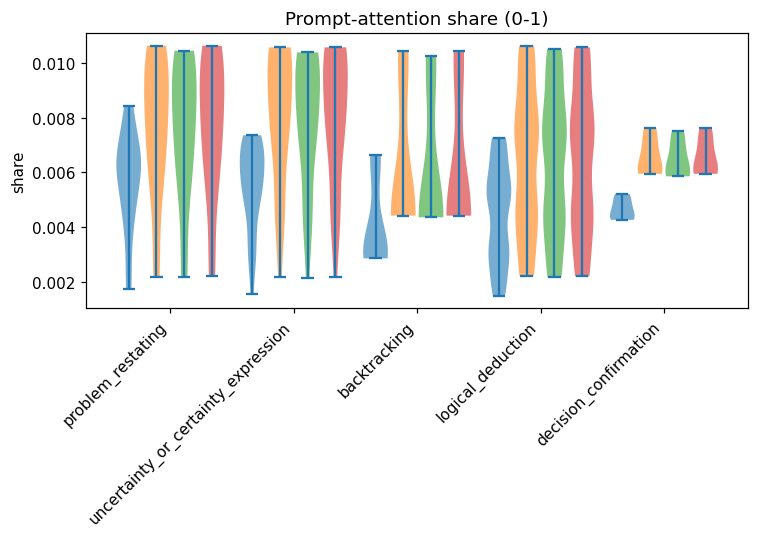

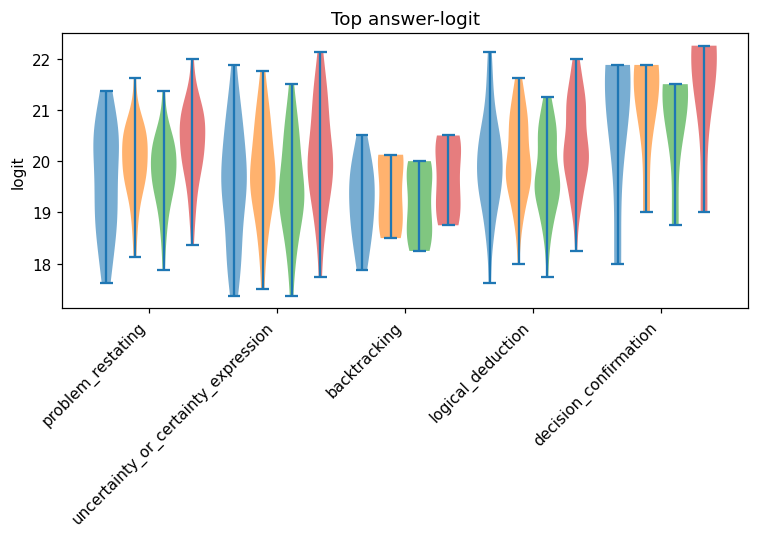

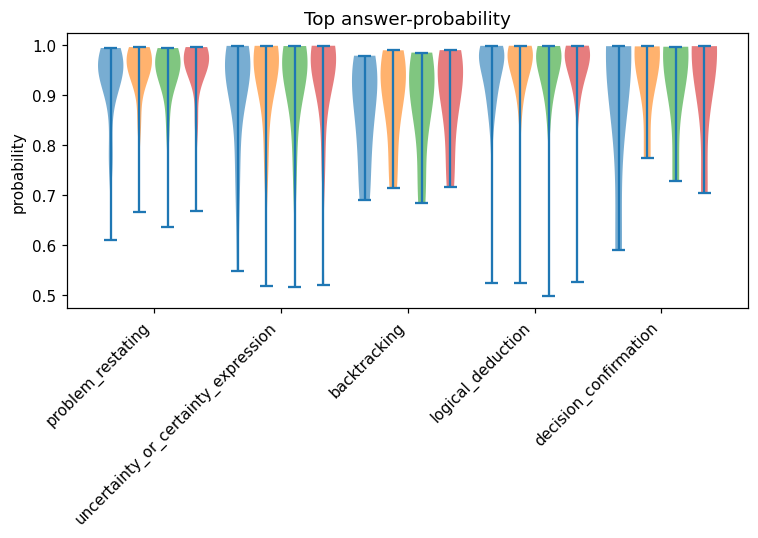

In [ ]:
import json, re, logging
from pathlib import Path
from typing import List, Dict, Tuple

import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

plt.rcParams["figure.dpi"] = 110
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s")
print("⚙️  running on", DEVICE)

# %% ── 2. Paths & high-level parameters ──────────────────────────────
MODEL_PATH      = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

COT_JSON        = ("data/mmlu/DeepSeek-R1-Distill-Llama-8B/sycophancy/"
                   "completions_with_5001.json")
SEGMENT_CAT_JSON= ("c_cluster_analysis/outputs/hints/mmlu/"
                   "DeepSeek-R1-Distill-Llama-8B/confidence/"
                   "sycophancy_unverb_5001.json")
HIDDEN_JSON     = ("c_cluster_analysis/outputs/hints/mmlu/"
                   "DeepSeek-R1-Distill-Llama-8B/cat_probe/"
                   "sycophancy_unverb_5001.json")
WHITELIST_JSON  = ("c_cluster_analysis/outputs/hints/mmlu/"
                   "DeepSeek-R1-Distill-Llama-8B/filter/"
                   "unverb_ids_5001_sycophancy.json")

ALPHA           = 1.0
MAX_QUESTIONS   = 10                 # None → use all whitelist
OPTION_LABELS   = ["A", "B", "C", "D"]
INTV_PROMPT     = "... The final answer is ["

GENERAL_CATS = ["problem_restating",
                "uncertainty_or_certainty_expression",
                "backtracking",
                "logical_deduction",
                "decision_confirmation"]

STEER_CATS   = ["problem_restating",
                "uncertainty_or_certainty_expression",
                "logical_deduction"]   # vectors used for steering

# %% ── 3. Helper: sentence split & category map ──────────────────────
whitelist_ids = {int(x) for x in json.loads(Path(WHITELIST_JSON).read_text())}

_SENT_RGX = re.compile(r"(?<=\.)\s+")
def split_sents(txt:str)->List[str]:
    start,end=txt.find("<think>"),txt.find("</think>")
    if start!=-1: txt=txt[start+7:]
    if end  !=-1: txt=txt[:end]
    txt=re.sub(r"\s+"," ",txt.strip())
    parts=[p.strip() for p in _SENT_RGX.split(txt) if p.strip()]
    merged,i=[],0
    while i<len(parts):
        if re.fullmatch(r"\d+\.",parts[i])and i+1<len(parts):
            merged.append(f"{parts[i]} {parts[i+1]}");i+=2
        else: merged.append(parts[i]);i+=1
    return merged

def load_cat_map(path)->Dict[Tuple[int,int],str]:
    out={}
    for blk in json.loads(Path(path).read_text()):
        qid=int(blk["question_id"])
        for row in blk["annotations"]:
            sid=int(row["sentence_id"])
            scores={k:v for k,v in row.items()
                    if k not in("sentence_id","other","other_label")}
            out[(qid,sid)]=max(scores,key=scores.get)
    return out
cat_map=load_cat_map(SEGMENT_CAT_JSON)

hidden_data=json.loads(Path(HIDDEN_JSON).read_text())
def mean_vec(cat)->torch.Tensor:
    vecs=[]
    for q in hidden_data:
        qid=int(q["question_id"])
        if qid not in whitelist_ids: continue
        for s in q["sentences"]:
            if cat_map.get((qid,int(s["sentence_id"])))==cat:
                vecs.append(np.array(s["sent_vec"],dtype=np.float32))
    if not vecs:
        raise ValueError(f"No vectors for category '{cat}'")
    return torch.tensor(np.mean(np.stack(vecs,0),0),device=DEVICE)

STEER_VECS={c:mean_vec(c) for c in STEER_CATS}
print("✓ steering vectors:",", ".join(f"{k}·{v.shape[-1]}"for k,v in STEER_VECS.items()))

tok=AutoTokenizer.from_pretrained(MODEL_PATH)
model=AutoModelForCausalLM.from_pretrained(
        MODEL_PATH,torch_dtype=torch.bfloat16).to(DEVICE).eval()
if tok.pad_token_id is None: tok.pad_token=tok.eos_token
model.config.pad_token_id=tok.eos_token_id
penult_layer=model.model.layers[-2]

def make_hook(alpha,vec):
    def _hook(_m,_i,out):
        h=out[0] if isinstance(out,tuple) else out
        q=h[:,-1,:]
        n=q.norm(p=2,dim=-1,keepdim=True)
        q2=q+alpha*vec
        q2=q2*(n/q2.norm(p=2,dim=-1,keepdim=True))
        h[:,-1,:]=q2
        return out
    return _hook

INTV_IDS=tok.encode(INTV_PROMPT,add_special_tokens=False)
OPT_IDS ={lbl: tok.encode(f" {lbl}", add_special_tokens=False)[0]
          for lbl in OPTION_LABELS}
def softmax_subset(d:Dict[str,float])->Dict[str,float]:
    vals=torch.tensor(list(d.values())); pr=torch.softmax(vals,0).tolist()
    return dict(zip(d.keys(),pr))

def probe(completion:str, steer_vec:torch.Tensor|None):
    think_pos=completion.find("<think>")
    prompt_ids=tok.encode(completion[:think_pos],add_special_tokens=False)

    sentences=split_sents(completion)
    ctx_ids,res=[],[]
    hook=penult_layer.register_forward_hook(
            make_hook(ALPHA,steer_vec)) if steer_vec is not None else None
    try:
        for sid,s in enumerate(sentences,1):
            ctx_ids.extend(tok.encode(s,add_special_tokens=False))
            seq=torch.tensor([prompt_ids+ctx_ids],device=DEVICE)
            with torch.no_grad():
                out1=model(seq,output_attentions=True)
            att=out1.attentions[-1][0]
            #share=float(att[:,-1,:len(prompt_ids)].sum(-1).mean().item())
            share=float(att[:,-1,:len(prompt_ids)].mean().item())

            seq2=torch.tensor([seq[0].tolist()+INTV_IDS],device=DEVICE)
            with torch.no_grad():
                logits=model(seq2).logits[0,-1]
            logit_dict={lbl:float(logits[tid]) for lbl,tid in OPT_IDS.items()}
            prob=max(softmax_subset(logit_dict).values())
            res.append(dict(sentence_id=sid,
                            share       = share,
                            top_logit   = max(logit_dict.values()),
                            top_prob    = prob,
                            answer_logits = logit_dict,
                            answer_probs  = softmax_subset(logit_dict)))
    finally:
        if hook: hook.remove(); torch.cuda.empty_cache()
    return res

all_cots=[c for c in json.loads(Path(COT_JSON).read_text())
          if int(c["question_id"]) in whitelist_ids]
if MAX_QUESTIONS: all_cots=all_cots[:MAX_QUESTIONS]

runs={"orig":None}|{c:v for c,v in STEER_VECS.items()}
records=[]
for label,vec in runs.items():
    print(f"▶ probing: {label}")
    for rec in tqdm(all_cots,desc=label):
        qid=int(rec["question_id"])
        rows=probe(rec["completion"], vec)
        for r in rows:
            r.update(dict(run=label,
                          question_id=qid,
                          category=cat_map.get((qid,r["sentence_id"]),"UNK")))
            records.append(r)

# --- after the records list is built, but *before* df = pd.DataFrame(records) ---
HINTS_JSON = "data/mmlu/hints_sycophancy.json"
hint_map   = {h["question_id"]: h["hint_option"] for h in json.loads(Path(HINTS_JSON).read_text())}

for r in records:
    hint = hint_map.get(r["question_id"])
    if hint is None:                        # should not happen with sycophancy file
        r["hint_logit"] = r["other_logit"] = r["hint_prob"] = r["other_prob"] = None
        continue
    hlog = r["answer_logits"][hint]
    hprob= r["answer_probs" ][hint]
    olog = max(v for k,v in r["answer_logits"].items() if k != hint)
    oprob= max(v for k,v in r["answer_probs" ].items() if k != hint)
    r.update(dict(hint_logit=hlog, other_logit=olog,
                  hint_prob =hprob, other_prob =oprob))

df=pd.DataFrame(records)

# focus on our five plotted categories
df=df[df.category.isin(GENERAL_CATS)]

palette={"orig":"#1f77b4",
         STEER_CATS[0]:"#ff7f0e",
         STEER_CATS[1]:"#2ca02c",
         STEER_CATS[2]:"#d62728"}


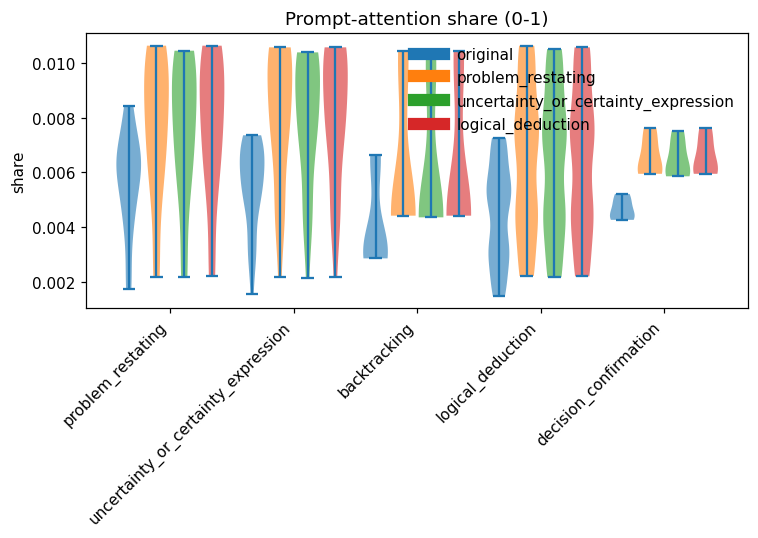

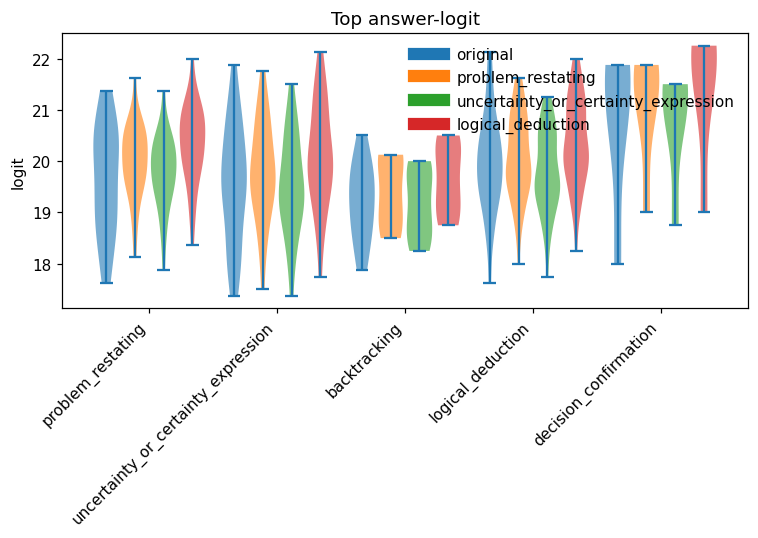

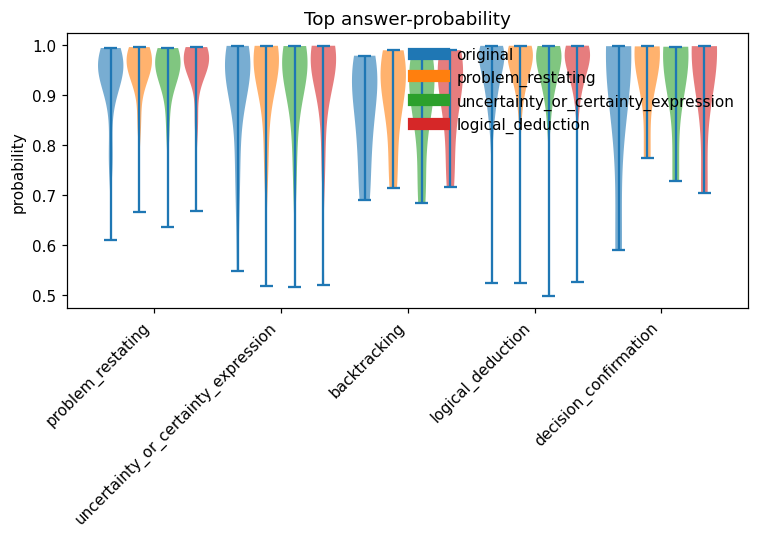

In [4]:
def violin(metric,title,ylabel):
    cats=GENERAL_CATS
    fig,ax=plt.subplots(figsize=(1.4*len(cats),5))
    pos,clr,data=[],[],[]
    for i,cat in enumerate(cats):
        for j,run in enumerate(["orig"]+STEER_CATS):
            vals=df[(df.category==cat)&(df.run==run)][metric].tolist()
            if not vals: continue
            data.append(vals); pos.append(i*4+j*0.9); clr.append(palette[run])
    vp=ax.violinplot(data,positions=pos,widths=0.8,showmeans=False)
    for body,c in zip(vp['bodies'],clr):
        body.set_facecolor(c); body.set_alpha(.6)
    ax.set_xticks([i*4+1.35 for i in range(len(cats))])
    ax.set_xticklabels(cats,rotation=45,ha="right")
        # build a legend -------------------------------------------------
    handles, labels = [], []
    for run in ["orig"] + STEER_CATS:
        if palette[run] in clr:                                # run actually plotted
            handles.append(plt.Line2D([], [], lw=8, color=palette[run]))
            labels .append("original" if run == "orig" else run)
    ax.legend(handles, labels, frameon=False, loc="upper right")

    ax.set_ylabel(ylabel); ax.set_title(title); plt.tight_layout(); plt.show()

violin("share","Prompt-attention share (0-1)","share")
violin("top_logit","Top answer-logit","logit")
violin("top_prob","Top answer-probability","probability")

In [14]:
from matplotlib.lines import Line2D

def violin(metric, title, ylabel, n_chars=6):   # n_chars = how many characters to keep
    cats = GENERAL_CATS
    fig, ax = plt.subplots(figsize=(1.4 * len(cats), 5))
    fig.subplots_adjust(right=0.80)             # keep 20 % width for legend

    pos, clr, data = [], [], []
    for i, cat in enumerate(cats):
        for j, run in enumerate(["orig"] + STEER_CATS):
            vals = df[(df.category == cat) & (df.run == run)][metric].tolist()
            if not vals:
                continue
            data.append(vals)
            pos.append(i * 4 + j * 0.9)
            clr.append(palette[run])

    vp = ax.violinplot(data, positions=pos, widths=0.8, showmeans=False)
    for body, c in zip(vp["bodies"], clr):
        body.set_facecolor(c)
        body.set_alpha(.6)

    ax.set_xticks([i * 4 + 1.35 for i in range(len(cats))])
    ax.set_xticklabels(cats, rotation=45, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # ── legend ──────────────────────────────────────────────────────
    handles, labels = [], []
    for run in ["orig"] + STEER_CATS:
        if palette[run] in clr:
            handles.append(Line2D([], [], lw=8, color=palette[run]))
            # NEW: shorten the label to n_chars and add an ellipsis if needed
            short = run if run == "orig" else run[:n_chars] + ("…" if len(run) > n_chars else "")
            labels.append(short)

    ax.legend(
        handles,
        labels,
        frameon=False,
        loc="center left",
        bbox_to_anchor=(1.01, 0.5)
    )

    fig.tight_layout()
    plt.show()


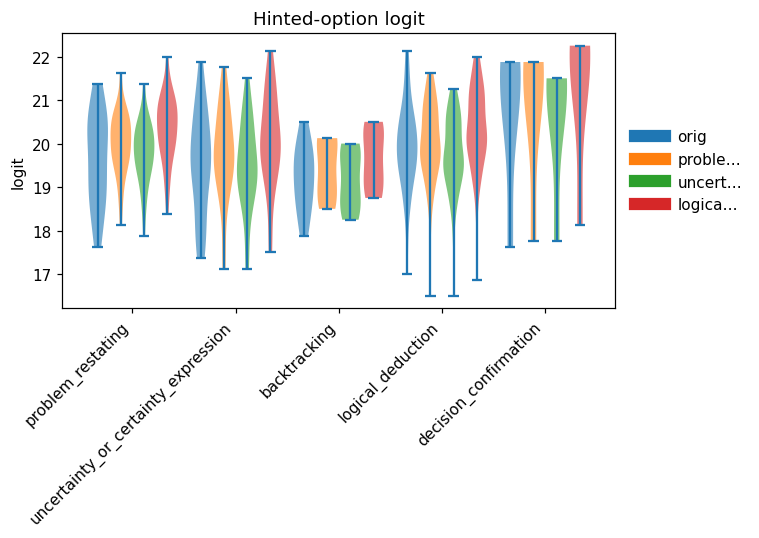

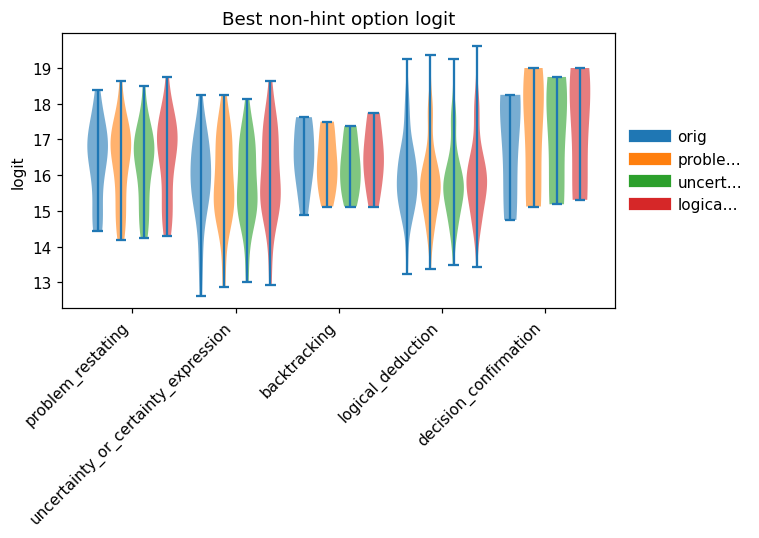

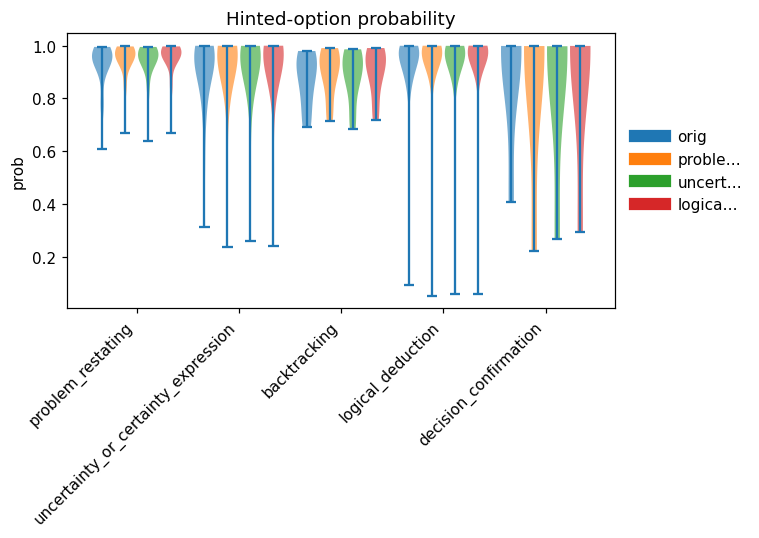

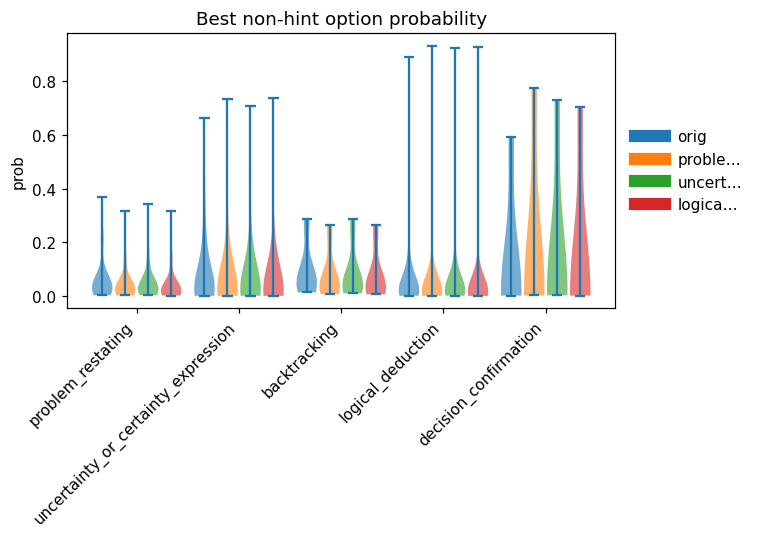

In [15]:
violin("hint_logit",  "Hinted-option logit",            "logit")
violin("other_logit", "Best non-hint option logit",     "logit")
violin("hint_prob",   "Hinted-option probability",      "prob")
violin("other_prob",  "Best non-hint option probability","prob")
